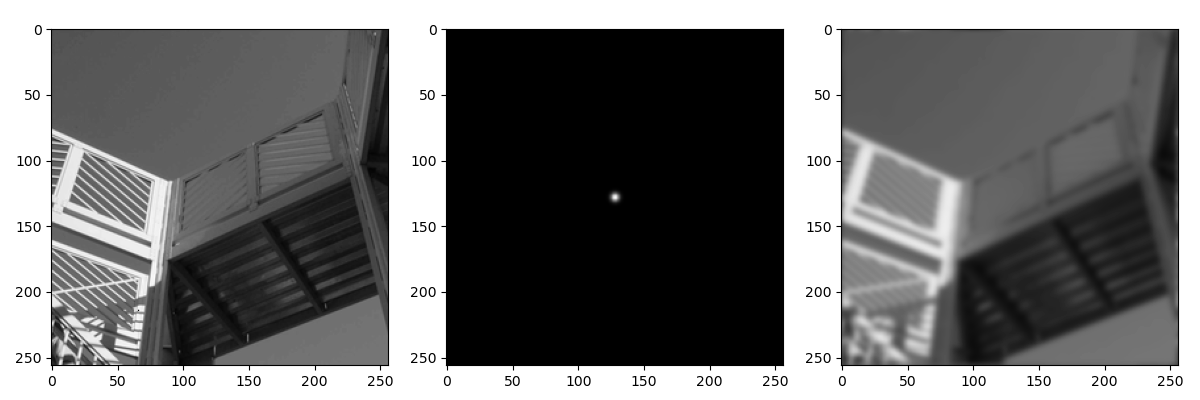

In [1]:
%matplotlib widget
import numpy as np
from numpy.fft import fftshift
import matplotlib.pyplot as plt
from scipy.misc import ascent

import pyopencl as cl
import pyopencl.array as cla
from pyvkfft.opencl import VkFFTApp
from pyvkfft.fft import rfftn, irfftn, fftn, ifftn

cl_ctx = cl.create_some_context()
cq = cl.CommandQueue(cl_ctx)

d = ascent()[:256,:256]
ny, nx = d.shape
y, x = np.meshgrid(np.arange(-ny//2,ny//2), np.arange(-nx//2,nx//2), indexing='ij')
g = np.fft.fftshift(np.exp(-(x**2+y**2)/10))
g /= g.sum()

# Numpy convolution
d, g = d.astype(np.float32), g.astype(np.float32)
gd_np = np.fft.irfftn(np.fft.rfftn(d) * np.fft.rfftn(g))


# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.float32))
g_gpu = cla.to_device(cq,g.astype(np.float32))

# Classic convolution
gd_gpu = irfftn(rfftn(d_gpu) * rfftn(g_gpu))
gd0 = gd_gpu.get()  # Reference result

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(d, cmap='gray')
plt.subplot(132)
plt.imshow(np.fft.fftshift(g), cmap='gray')
plt.subplot(133)
plt.imshow(gd_gpu.get(), cmap='gray', vmin=0,vmax=255)
plt.tight_layout()


VkFFTApp[OpenCL]:(256,256+2)     R2C/s/i [rr] [11] buf=    0       0  


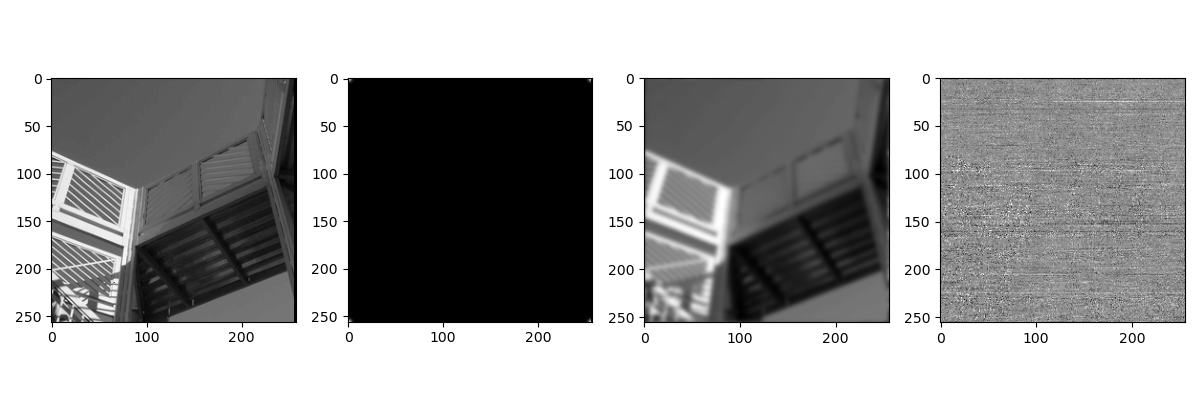

In [2]:
# Inplace R2C with on-the-fly VkFFT convolution
d1 = np.pad(d,((0,0),(0,2)))
g1 = np.pad(g,((0,0),(0,2)))

d_gpu = cla.to_device(cq, d1.astype(np.float32))
g_gpu = cla.to_device(cq, g1.astype(np.float32))

k_gpu = rfftn(g_gpu, g_gpu)

app = VkFFTApp(d1.shape, dtype=np.float32, queue=cq, ndim=2, inplace=True,r2c=True,convolve=True, convolve_conj=0)
app.fft(d_gpu,convolve_kernel=k_gpu)
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(d1, cmap='gray')
plt.subplot(142)
plt.imshow(g1, cmap='gray')
plt.subplot(143)
plt.imshow(d_gpu.get()[:,:-2], cmap='gray')
plt.subplot(144)
plt.imshow(d_gpu.get()[:,:-2]-gd0, cmap='gray')
plt.tight_layout()


VkFFTApp[OpenCL]:(256,256)       C2C/s/i [rr] [11] buf=    0       0  


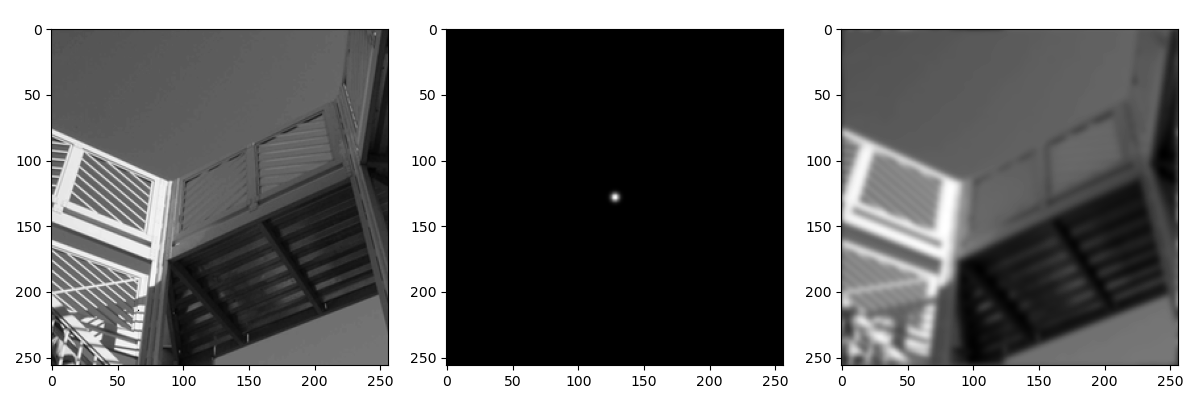

In [3]:
# Inplace C2C VkFFT convolve
d_gpu = cla.to_device(cq, d.astype(np.complex64))
g_gpu = cla.to_device(cq, g.astype(np.complex64))

k_gpu = fftn(g_gpu)

app = VkFFTApp(d.shape, dtype=np.complex64, queue=cq, ndim=2, inplace=True,convolve=True, convolve_conj=0)
gd_gpu = app.fft(src=d_gpu,convolve_kernel=k_gpu)
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(d, cmap='gray')
plt.subplot(132)
plt.imshow(np.fft.fftshift(g), cmap='gray')
plt.subplot(133)
plt.imshow(abs(gd_gpu.get()), cmap='gray')
plt.tight_layout()


VkFFTApp[OpenCL]:(256,256)       C2C/s/o [rr] [11] buf=    0       0  


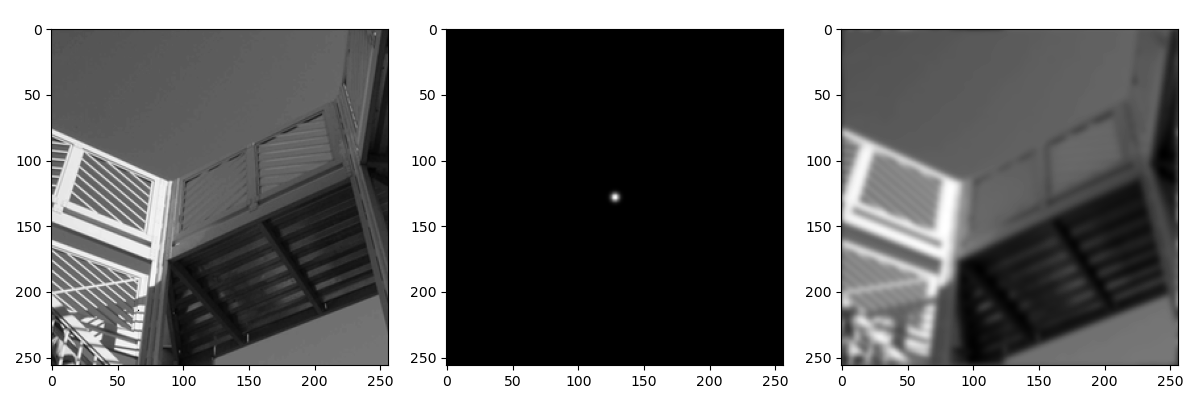

In [4]:
# Out-of-place C2C VkFFT convolve
d_gpu = cla.to_device(cq, d.astype(np.complex64))
g_gpu = cla.to_device(cq, g.astype(np.complex64))
gd_gpu = cla.empty_like(d_gpu)

k_gpu = fftn(g_gpu)

app = VkFFTApp(d.shape, dtype=np.complex64, queue=cq, ndim=2, inplace=False,convolve=True, convolve_conj=0, convolve_norm=0)
gd_gpu = app.fft(src=d_gpu, dest=gd_gpu,convolve_kernel=k_gpu)
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(d, cmap='gray')
plt.subplot(132)
plt.imshow(np.fft.fftshift(g), cmap='gray')
plt.subplot(133)
plt.imshow(abs(gd_gpu.get()), cmap='gray')
plt.tight_layout()
